# Basic analysis template for the students 

Should you need anything else, such as BPMs, just tell me !

## Instructions:
- To insert manually the momentum spread from the tomoscope use the first cell in the tomoscope section
- Else use the second and the third in the same section

In [1]:
%run /eos/project/m/mte/Toolbox/myToolbox.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.2.2.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/Injection_missteering
Your IP is 172.17.0.11
2017-10-25 11:23:32


In [2]:
# matlab data path
dataPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/data/2017*.mat'


files = sorted(glob.glob(dataPath))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 251 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/data/2017.10.20.11.58.07.906.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/data/2017.10.20.14.41.25.593.mat


In [3]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1','PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                                                     'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1','PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                                                     'PR_BPM.AcquisitionOrbit.value.position',
                                                    'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                                                    'PR_BCT_ST.Samples.value.samples','PI_KFA45.AQN1.value'],verbose=False)                                                        

In [4]:
# data cleanup
# drop duplicates keeping the first acquisition
myDataFrame = myDataFrame.drop_duplicates(['cycleStamp'],keep='first')

# wirescanner fault
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-10-20 14:06:45.100'].name)

## Intensity

In [5]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses_perc'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][110]/np.max(x) )

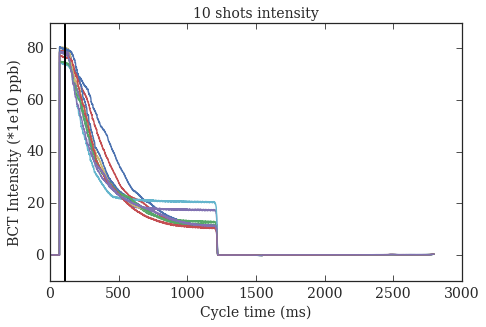

In [6]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=110, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')

## Tomoscope

In [7]:
myDataFrame['deltaP_P_rms']=8.34e-4

In [8]:
# Run this only if you want to acquire the momentum spread point by point
tomoPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/*.dat'
timeTolerance = 9 # [seconds] # set tolerance to align the timestamps


# and there it goes
%run /eos/user/e/esenes/tomogram.py

# list files and prepare the dataframe for the results
files_tomo=sorted(glob.glob(tomoPath))
tomoDfPS = pnd.DataFrame()

for f in range(len(files_tomo)):
    tomo_d = extractProfile(files_tomo[f])
    if tomo_d is np.nan:
        pass
    else:
        tomoDfPS=tomoDfPS.append(tomo_d,ignore_index=True)
        
        
# work ou the dataframe for the alignment
myDataFrame['tomoTimestamp']=np.nan
myDataFrame['tomoDelta']=np.nan
myDataFrame['deltaP_P_rms']=np.nan
myDataFrame['peakLineDensity']=np.nan


succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomoDfPS)):
    tomo_local_cs = tomoDfPS['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    #stuff to copy here
    current_dpprms = tomoDfPS['deltaP_P_RMS'].values[k]
    current_pkld = tomoDfPS['peakLineDensity'].values[k]

    # loop over the matlab data
    for x in range(len(myDataFrame)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()

        if np.abs(d) <= timeTolerance and x > last_match: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame['tomoDelta'].iloc[x] = d
            myDataFrame['deltaP_P_rms'].iloc[x] = current_dpprms
            myDataFrame['peakLineDensity'].iloc[x]=current_pkld

            
            succ_count += 1 #dummy counter

# discard the elements without tomogram (are probably double shots of matlab)
discFlag = np.isnan(myDataFrame['tomoDelta'].values)
myDataFrame = myDataFrame.drop(myDataFrame.loc[discFlag].index)

Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_001.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_002.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_003.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_004.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_005.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_006.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_007.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_008.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceB

Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_072.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_073.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_074.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_075.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_076.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_077.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_078.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_079.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceB

Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_142.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_143.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_144.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_145.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_146.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_147.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_148.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_149.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceB

Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_213.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_214.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_215.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_216.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_217.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_218.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_219.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_220.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceB

Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_284.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_285.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_286.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_287.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_288.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_289.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_290.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_291.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceB

Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_354.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_355.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_356.dat
Treating file /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.20/tomo_data/autosave_357.dat


/cvmfs/sft.cern.ch/lcg/views/LCG_91/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
print str(succ_count) +"/"+ str(len(tomoDfPS)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame)) 

137/355 are within the timeTolerance
length of dataframe is: 137


## Wire scanners

In [10]:
def normalised_emittance(sig, dp):
    "Calculate the normalised emittance, where sig is in mm. dp is DeltaP/P rms"
    betar = 0.915095 
#     D = 2.330216464 #at wirescanner 68
    D = 3.24577470 #at wirescanner 65
#     D = 2.27815054 #at wirescanner 54
#     betax = 13.00860302 #at wirescanner 68
    betax = 21.77988929 #at wirescanner 65
#     betax = 12.45331755 #at wirescanner 54
    
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2 - D**2*dp**2)/betax *(betar*gammar)
    return emi*1e6

def normalised_emittance_y(sig):
    "Calculate the normalised emittance without the dispesive component"
    betar = 0.915095
    betay = 11.44763004 #[metres] #at wirescanner 85
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2)/betay *(betar*gammar)
    return emi*1e6
    

### Y plane

In [11]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [12]:
#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

In [13]:
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

In [14]:
#now you have sigma, calculate the emittance
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance_y(x))

### X plane

In [15]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [16]:
#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  

In [17]:
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])

In [18]:
#now you have sigma, get the emitance
myDataFrame['WS_emittance_x'] = np.nan
for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance(myDataFrame['WS_sigma_x'].values[n],8.35e-4)

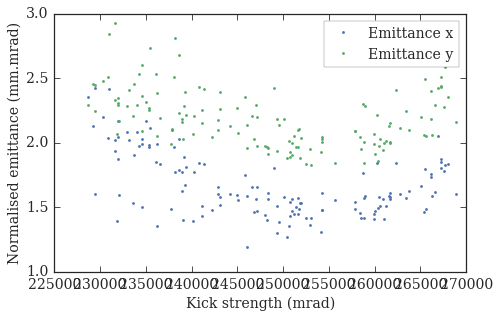

In [19]:
#plotting stuff
Emittance_x, = plt.plot(1e3*myDataFrame['PI_KFA45.AQN1.value'],myDataFrame['WS_emittance_x'],'.',label='Emittance x')
plt.xlabel('Kick strength (mrad)')
plt.ylabel('Normalised emittance (mm.mrad)')
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')
# set axis to get rid of some bad shots
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,5.5))


Emittance_y, = plt.plot(1e3*myDataFrame['PI_KFA45.AQN1.value'],myDataFrame['WS_emittance_y'],'.',label='Emittance y')

legend = plt.legend(handles=[Emittance_x,Emittance_y],frameon=True)

plt.show()